Change the positions of the galaxies in a SHAM to be shuffled then NFW-distributed, instead of on the subhalos. 

Shuffling procedure is as followed, from Jeremey

procedure:

take a bin in halo mass (small bins, like 0.1dex wide). (this is all halos, regardless of whether they have a galaxy in them or not). take all the centrals and put them in a list. take all the satellites and put them in a separate list.

randomly assign the centrals to all the halos in the bin.

randomly assign each satellite to a halo in the bin (repeat until all satellites are gone. this should preserve poisson distribution of satellite occupation). when assigning a satellite to a halo, preserve the position of the satellite and velocity of the satellite relative to the original host halo. ie, your list of satllites has dx, dy, dz, and dvx, dvy, dvz, then you add x, y, z, and vx, vy, vz of the new halo to those quantities.

In [142]:
import numpy as np
import astropy
from itertools import izip
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from pearce.mocks.customHODModels import *
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.utils import *
from halotools.mock_observables import tpcf

In [143]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [144]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
Lbox = 400.0
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')
catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [145]:
catalog = catalog[catalog['halo_mvir'] > 200*PMASS]

In [146]:
catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [147]:
add_halo_hostid(catalog, delete_possibly_existing_column=True)

In [148]:
for prop in ['halo_x', 'halo_y', 'halo_z', 'halo_nfw_conc', 'halo_mvir', 'halo_rvir']:
    broadcast_host_halo_property(catalog, prop, delete_possibly_existing_column=True)

In [149]:
r_bins = np.logspace(-1.1, 1.6, 18)
rbc = (r_bins[1:]+r_bins[:-1])/2

In [150]:
from halotools.utils.table_utils import compute_prim_haloprop_bins
from math import ceil
min_log_mass = np.log10(np.min(catalog['halo_mvir']))-0.001
max_log_mass = np.log10(np.max(catalog['halo_mvir']))+0.001
dlog10_prim_haloprop = 0.1
num_prim_haloprop_bins = (max_log_mass - min_log_mass) / dlog10_prim_haloprop
prim_haloprop_bin_boundaries = np.logspace(min_log_mass, max_log_mass,
    num=int(ceil(num_prim_haloprop_bins)))

prim_haloprop_bins = compute_prim_haloprop_bins(prim_haloprop = catalog['halo_mvir_host_halo'],\
                                                dlog10_prim_haloprop=dlog10_prim_haloprop,
                                                prim_haloprop_bin_boundaries = prim_haloprop_bin_boundaries)

In [151]:
shuffled_pos = np.zeros((len(catalog), 3))
shuffled_upids = np.zeros((len(catalog)))
shuffled_host_mvir = np.zeros((len(catalog)))

In [152]:
shuffled_mags = np.zeros((len(catalog), 3))
#shuffled_mags[:, 0] = catalog['halo_vpeak_mag']
#shuffled_mags[:, 1] = catalog['halo_vvir_mag']
#shuffled_mags[:, 2] = catalog['halo_alpha_05_mag']

In [153]:
from pearce.mocks import cat_dict
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
cat.load_model(1.0, HOD = 'redMagic')

In [154]:
bins_in_halocat = set(prim_haloprop_bins)

for ibin in bins_in_halocat:
    print ibin
 
    indices_of_prim_haloprop_bin = np.where(prim_haloprop_bins == ibin)[0]
    
    centrals_idx = np.where(catalog[indices_of_prim_haloprop_bin]['halo_upid'] == -1)[0]
    n_centrals = len(centrals_idx)
    satellites_idx = np.where(catalog[indices_of_prim_haloprop_bin]['halo_upid']!=-1)[0]
    n_satellites = len(satellites_idx)
    
    if centrals_idx.shape[0]!=0:
        rand_central_idxs = np.random.choice(indices_of_prim_haloprop_bin[centrals_idx], size = n_centrals, replace = False)
    else:
        rand_central_idxs = np.array([])

    for idx, coord in enumerate(['vpeak', 'vvir', 'alpha_05']):
        shuffled_mags[indices_of_prim_haloprop_bin[centrals_idx], idx]= \
                catalog[rand_central_idxs]['halo_'+coord+'_mag']
            
        shuffled_mags[indices_of_prim_haloprop_bin[satellites_idx],idx ] = \
                catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_'+coord+'_mag']
    #Create second rand_central_idxs, Iterate through satellite hosts and assign them when they match. 
    
    for idx, coord in enumerate(['x','y','z']):
        # don't need to shuffle positions cu we've shuffled mags for centrals
        shuffled_pos[indices_of_prim_haloprop_bin[centrals_idx], idx] = \
                catalog[indices_of_prim_haloprop_bin[centrals_idx]]['halo_'+coord]
            
    shuffled_upids[indices_of_prim_haloprop_bin[centrals_idx]] = -1
    
    shuffled_host_mvir[indices_of_prim_haloprop_bin[centrals_idx]] = \
            catalog[indices_of_prim_haloprop_bin[centrals_idx]]['halo_mvir']
        
    unique_hosts_id, first_sat_idxs, inverse_idxs = np.unique(catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_upid'],\
                                                       return_index=True, return_inverse=True)

    shuffled_idxs = np.random.permutation(unique_hosts_id.shape[0])
    shuffled_hosts_id = unique_hosts_id[shuffled_idxs]
    shuffled_sat_idxs = first_sat_idxs[shuffled_idxs]
    shuffled_arrays_idx = 0
    host_map = dict() #maps the current host id to the index of a new host id. 
    #the host_id -> idx map is easier than the host_id -> host_id map
    
    new_host_ids = shuffled_hosts_id[inverse_idxs]
    hosts_old_satellite_idxs = shuffled_sat_idxs[inverse_idxs]
    '''
    for iii, sat_idx in enumerate(satellites_idx):
        host_id = catalog[indices_of_prim_haloprop_bin[sat_idx]]['halo_upid']
        
        if host_id in host_map:
            new_host_id, hosts_old_satellite_idx = host_map[host_id]
        else:
            new_host_id = shuffled_hosts_id[shuffled_arrays_idx]
            hosts_old_satellite_idx = shuffled_sat_idxs[shuffled_arrays_idx]
            host_map[host_id] = (new_host_id, hosts_old_satellite_idx)
            shuffled_arrays_idx+=1
        
        #print new_host_id, new_host_ids[iii]
        #print hosts_old_satellite_idx, hosts_oldsatellite_idxs[iii]
    break
    '''
            
    shuffled_upids[indices_of_prim_haloprop_bin[satellites_idx]] = new_host_ids
    
    if np.any(shuffled_upids[indices_of_prim_haloprop_bin] == 0.0):
        print ibin
        print np.sum(shuffled_upids[indices_of_prim_haloprop_binces_of_prim_haloprop_bin]==0.0)

    shuffled_host_mvir[indices_of_prim_haloprop_bin[satellites_idx]] = \
            catalog[indices_of_prim_haloprop_bin[satellites_idx]][hosts_old_satellite_idxs]['halo_mvir_host_halo']


    hc_x, hc_y, hc_z = cat.model.model_dictionary['satellites_profile'].mc_halo_centric_pos(\
                                                    catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_nfw_conc_host_halo'],
                                                    halo_radius = catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_rvir_host_halo'])


    for idx, (coord, hc) in enumerate(izip(['x','y','z'], [hc_x, hc_y, hc_z])):
        #shuffled_pos[indices_of_prim_haloprop_bin[satellites_idx], idx] = \
        #        (catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_'+coord] -\
        #        host_halo_pos[indices_of_prim_haloprop_bin[satellites_idx], idx]+\
        #        host_halo_pos[rand_host_idxs, idx])%Lbox

        #shuffled_pos[indices_of_prim_haloprop_bin[satellites_idx],idx] =\
        #            (catalog[indices_of_prim_haloprop_bin[satellites_idx][hosts_old_satellite_idxs]]['halo_'+coord+'_host_halo'] + hc)%Lbox
        shuffled_pos[indices_of_prim_haloprop_bin[satellites_idx], idx] = \
                (catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_'+coord] -\
                 catalog[indices_of_prim_haloprop_bin[satellites_idx]]['halo_'+coord+'_host_halo']+\
                 catalog[indices_of_prim_haloprop_bin[satellites_idx]][hosts_old_satellite_idxs]['halo_'+coord+'_host_halo'])%Lbox

                             

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [155]:
catalog['halo_sh_shuffled_vpeak_mag'] = shuffled_mags[:,0]
catalog['halo_sh_shuffled_vvir_mag'] = shuffled_mags[:,1]
catalog['halo_sh_shuffled_alpha_05_mag'] = shuffled_mags[:,2]
catalog['halo_sh_shuffled_x'] = shuffled_pos[:,0]
catalog['halo_sh_shuffled_y'] = shuffled_pos[:,1]
catalog['halo_sh_shuffled_z'] = shuffled_pos[:,2]
catalog['halo_sh_shuffled_upid']=shuffled_upids[:]
catalog['halo_sh_shuffled_host_mvir'] = shuffled_host_mvir[:]

In [156]:
r_bins = np.logspace(-1.1, 1.6, 18)
rbc = (r_bins[1:]+r_bins[:-1])/2

In [157]:
galaxy_catalog = catalog[catalog['halo_vpeak_mag'] <= -21]

In [158]:
mock_pos = np.c_[galaxy_catalog['halo_x'],\
                     galaxy_catalog['halo_y'],\
                     galaxy_catalog['halo_z']]
sham_xi = tpcf(mock_pos, r_bins , period=400.0, num_threads=1)

In [159]:
galaxy_catalog = catalog[catalog['halo_shuffled_vpeak_mag'] <= -21]

In [160]:
mock_pos = np.c_[galaxy_catalog['halo_sh_shuffled_x'],\
                 galaxy_catalog['halo_sh_shuffled_y'],\
                 galaxy_catalog['halo_sh_shuffled_z']]
shuffled_xi = tpcf(mock_pos, r_bins , period=400.0, num_threads=1)

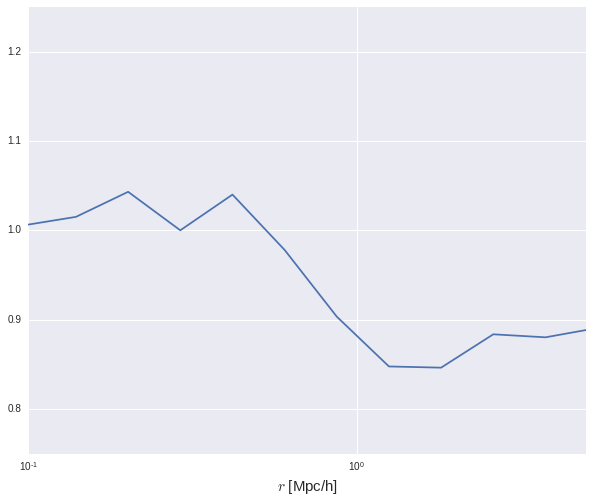

In [161]:
plt.figure(figsize=(10,8))
plt.plot(rbc, shuffled_xi/sham_xi)
plt.xscale('log')
plt.legend(loc='best')
plt.xlim([1e-1, 5e0]);
plt.ylim([0.75,1.25]);
plt.xlabel(r'$r$ [Mpc/h]',fontsize = 15)
#plt.ylabel(r'$\xi_{X} (r)/\xi_{SHAM} (r)$',fontsize = 15)
#plt.title(r'$\xi (r)$ ratio for model X/SHAM, %s'%mag_type, fontsize = 20)

In [162]:
%%bash
ls -lt *.hdf5

-rw-r--r-- 1 swmclau2 des 794838268 Oct 16 21:25 abmatched_halos.hdf5


In [163]:
Lbox = 1000.0
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')
ab_property = 'halo_vmax@mpeak'
sh_catalog = astropy.table.Table.read('../catalog_ab_%s_shuffled.hdf5'%ab_property, format = 'hdf5')

In [164]:
catalog = astropy.table.Table.read('../catalog_ab_%s.hdf5'%ab_property, format = 'hdf5')

In [165]:
from halotools.mock_observables import tpcf

In [166]:
len(sh_catalog), len(catalog)

(420000, 95969198)

In [167]:
nd = 4.2e-4 #nd of final cat 
n_obj_needed = int(nd*(1000.0**3))
sort_idxs = np.argsort(catalog['gal_smass'])
catalog = catalog[sort_idxs[:n_obj_needed]]
sort_idxs = np.argsort(sh_catalog['gal_smass'])
sh_catalog = sh_catalog[sort_idxs[:n_obj_needed]]

In [168]:
len(catalog)

420000

(array([ 35200.,  35616.,  36397.,  36463.,  35341.,  36013.,  34995.,
         37134.,  35460.,  35318.]),
 array([  2.46999995e-03,   1.00001893e+02,   2.00001317e+02,
          3.00000740e+02,   4.00000164e+02,   4.99999587e+02,
          5.99999010e+02,   6.99998434e+02,   7.99997857e+02,
          8.99997281e+02,   9.99996704e+02]),
 <a list of 10 Patch objects>)

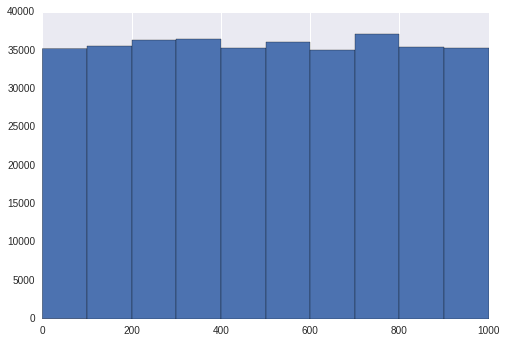

In [169]:
plt.hist(sh_catalog[sh_catalog['halo_upid']==-1]['halo_x'])

In [170]:
rbins = np.logspace(-1, 1.6, 18)
xi = tpcf(np.c_[catalog['halo_x'], catalog['halo_y'], catalog['halo_z']],rbins, period=Lbox )

In [171]:
sh_xi = tpcf(np.c_[sh_catalog['halo_x'], sh_catalog['halo_y'],\
                   sh_catalog['halo_z']],rbins, period=Lbox )

In [172]:
np.log10(sh_xi)

array([ 3.67454142,  3.38229835,  3.0758838 ,  2.76885344,  2.41782908,
        2.0066631 ,  1.60576655,  1.2490129 ,  0.97391208,  0.73937097,
        0.50400223,  0.26005055,  0.00531705, -0.25770528, -0.55083537,
       -0.87000485, -1.24048386])

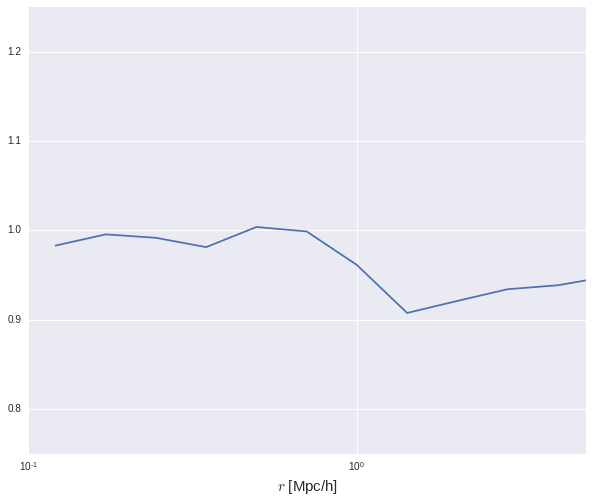

In [173]:
rbc = (rbins[1:]+rbins[:-1])/2
#plt.plot(rbc,sh_xi)
plt.figure(figsize=(10,8))
plt.plot(rbc, sh_xi/xi)

plt.xscale('log')
plt.legend(loc='best')
plt.xlim([1e-1, 5e0]);
plt.ylim([0.75,1.25]);
plt.xlabel(r'$r$ [Mpc/h]',fontsize = 15)

In [174]:
from collections import Counter

In [175]:
c1 = Counter(catalog['halo_upid'])
c1.most_common(10)

[(-1, 357937),
 (5509701498, 18),
 (5519871035, 15),
 (5587208456, 13),
 (5577648978, 12),
 (5522994639, 12),
 (5557612915, 12),
 (5587254222, 12),
 (5491707271, 12),
 (5561769120, 12)]

In [176]:
c2 = Counter(catalog['halo_sh_shuffled_upid'])
c2.most_common(10)

KeyError: 'halo_sh_shuffled_upid'